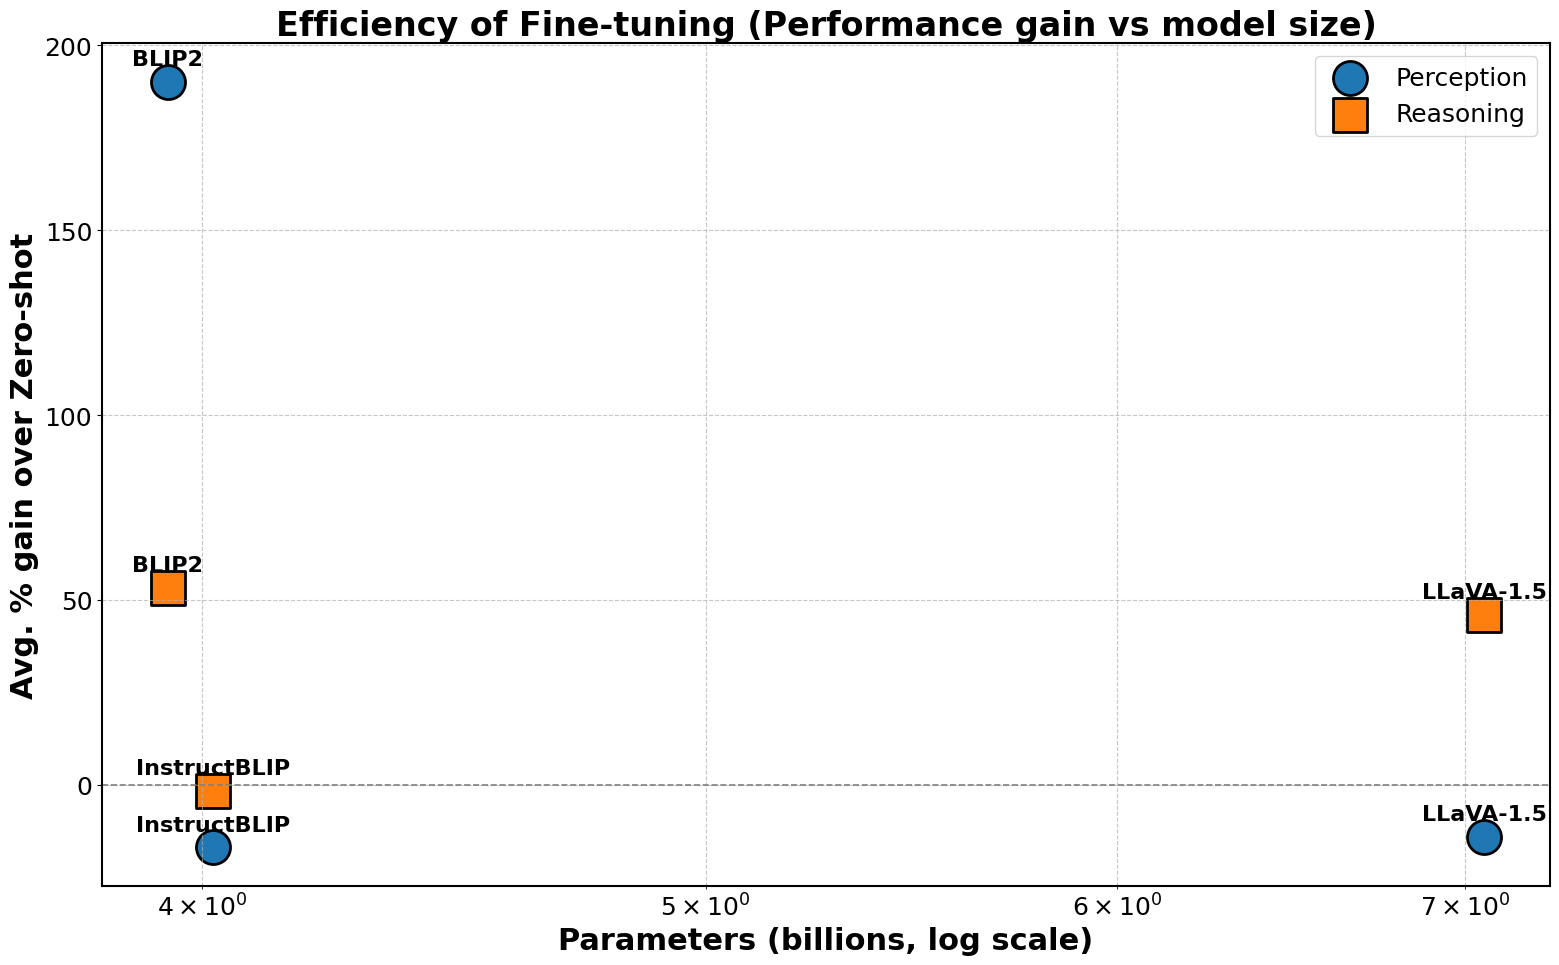

In [28]:
# Full reproducible notebook‑style script (refined)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, LogLocator

# === 1. Load CSV ===
csv_path = "stats.csv"   # adjust if you saved elsewhere
df = pd.read_csv(csv_path)

# === 2. Compute % performance gain (FT vs Zero‑shot) ===
mae_metrics = ["Prop_Scalar_MAE", "Obj_Count_MAE"]
f1_metrics = [c for c in df.columns if c not in ["Model", "Setup"] + mae_metrics]

records = []
for model in df["Model"].unique():
    zs = df[(df["Model"] == model) & (df["Setup"].str.contains("Zero-shot"))].iloc[0]
    ft = df[(df["Model"] == model) & (~df["Setup"].str.contains("Zero-shot"))].iloc[0]

    change = {}
    for m in mae_metrics:
        change[m] = (zs[m] - ft[m]) / zs[m] * 100  # ↓ MAE = improvement
    for m in f1_metrics:
        change[m] = (ft[m] - zs[m]) / zs[m] * 100  # ↑ F1 = improvement

    records.append({"Model": model, **change})

pct_df = pd.DataFrame(records).set_index("Model").round(2)

# === 3. Aggregate into broader categories ===
buckets = {
    "Perception_F1": [
        "Prop_Binary_F1", "Depth_Cat_F1", "Depth_ClosestObj_F1", "Depth_Binary_F1",
        "Layout_Binary_F1", "Layout_TopEntity_F1",
        "Obj_Presence_F1", "Obj_Coocc_F1"
    ],
    "Perception_MAE": mae_metrics,
    "Reasoning_F1": ["Reason_Negation_F1", "Reason_Counterf_F1", "Reason_Multihop_F1"],
}

agg = {}
for model, row in pct_df.iterrows():
    agg[model] = {bucket: row[cols].mean() for bucket, cols in buckets.items()}

agg_df = pd.DataFrame(agg).T.round(2)

# === 4. Parameter counts (billions) ===
param_counts = {
    "LLaVA-1.5": 7.06,
    "InstructBLIP": 4.02,
    "BLIP2": 3.94,
}

# === 5. Build 6‑point dataset ===
perception_avg = {m: (agg_df.loc[m, "Perception_F1"] + agg_df.loc[m, "Perception_MAE"]) / 2
                  for m in agg_df.index}
reasoning_gain = agg_df["Reasoning_F1"].to_dict()

plot_rows = []
for m in agg_df.index:
    plot_rows.append([m, "Perception", param_counts[m], perception_avg[m]])
    plot_rows.append([m, "Reasoning", param_counts[m], reasoning_gain[m]])

plot_df = pd.DataFrame(plot_rows, columns=["Model", "Task", "Params_B", "Gain_%"])

# === 6. Visualise (prettier & more intuitive) ===
plt.rcParams.update({'font.size': 18})  # Set global font size

plt.figure(figsize=(16, 10))

marker_map = {"Perception": "o", "Reasoning": "s"}
color_map = {"Perception": "tab:blue", "Reasoning": "tab:orange"}

for task in ["Perception", "Reasoning"]:
    sub = plot_df[plot_df["Task"] == task]
    plt.scatter(
        sub["Params_B"], sub["Gain_%"],
        marker=marker_map[task],
        color=color_map[task],
        s=600,  # bigger dots
        edgecolors="black",
        linewidth=2.0,  # thicker border
        alpha=1.0,  # fully solid
        label=task
    )

# annotate every point with the model name
for _, r in plot_df.iterrows():
    plt.annotate(
        r["Model"],
        (r["Params_B"], r["Gain_%"]),
        textcoords="offset points",
        xytext=(0, 12),  # slightly more vertical spacing
        ha="center",
        fontsize=16,  # larger annotation
        weight='bold'
    )

plt.xscale("log")
plt.xlabel("Parameters (billions, log scale)", fontsize=22, weight='bold')
plt.ylabel("Avg. % gain over Zero-shot", fontsize=22, weight='bold')
plt.title("Efficiency of Fine-tuning (Performance gain vs model size)", fontsize=24, weight='bold')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.axhline(0, linestyle="--", linewidth=1.2, color="gray")

plt.gca().xaxis.set_major_locator(LogLocator(base=10, numticks=10))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:g}"))

plt.grid(True, which="both", linestyle="--", linewidth=0.8, alpha=0.7)

plt.legend(fontsize=18)

# Make plot border thicker
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig("efficiency_plot.png", dpi=300, bbox_inches='tight') 


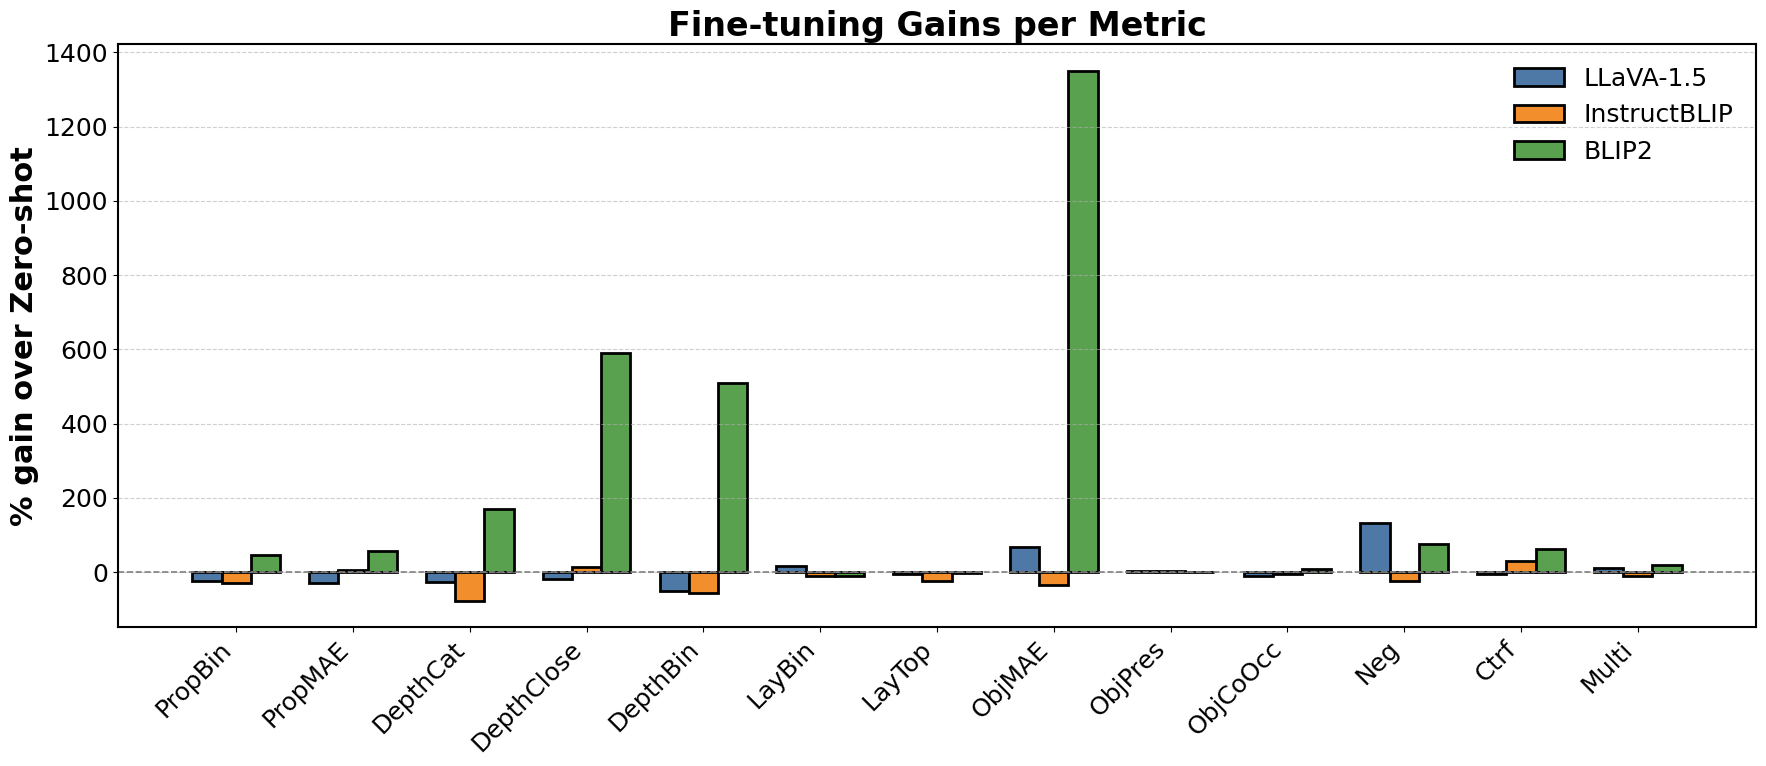

In [31]:
import pandas as pd

# Load CSV
df = pd.read_csv("stats.csv")

mae_metrics = ["Prop_Scalar_MAE", "Obj_Count_MAE"]
f1_metrics = [c for c in df.columns if c not in ["Model", "Setup"] + mae_metrics]

# Compute percent change
records = []
for model in df["Model"].unique():
    zs = df[(df["Model"] == model) & (df["Setup"].str.contains("Zero-shot"))].iloc[0]
    ft = df[(df["Model"] == model) & (~df["Setup"].str.contains("Zero-shot"))].iloc[0]

    changes = {}
    for m in mae_metrics:
        changes[m] = (zs[m] - ft[m]) / zs[m] * 100  # lower is better
    for m in f1_metrics:
        changes[m] = (ft[m] - zs[m]) / zs[m] * 100  # higher is better

    records.append({"Model": model, **changes})

pct_df = pd.DataFrame(records).set_index("Model").round(1)

metric_cols = [c for c in pct_df.columns]      # all 14 %-change columns
long_rows = []
for model in pct_df.index:                     # LLaVA / InstructBLIP / BLIP2
    for metric in metric_cols:
        long_rows.append([model, metric, pct_df.loc[model, metric]])

long_df = pd.DataFrame(long_rows,
                       columns=["Model", "Metric", "Gain_%"])

# Optional: nicer x-labels
metric_map = {
    "Prop_Binary_F1": "PropBin",
    "Prop_Scalar_MAE": "PropMAE",
    "Depth_Cat_F1": "DepthCat",
    "Depth_ClosestObj_F1": "DepthClose",
    "Depth_Binary_F1": "DepthBin",
    "Layout_Binary_F1": "LayBin",
    "Layout_TopEntity_F1": "LayTop",
    "Obj_Count_MAE": "ObjMAE",
    "Obj_Presence_F1": "ObjPres",
    "Obj_Coocc_F1": "ObjCoOcc",
    "Reason_Negation_F1": "Neg",
    "Reason_Counterf_F1": "Ctrf",
    "Reason_Multihop_F1": "Multi",
}
long_df["MetricLbl"] = long_df["Metric"].map(metric_map)

# === 4. Plot ALL metrics, three bars each  ===============================
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(18, 8))

# colours for the three models
cmap = {"LLaVA-1.5": "#4E79A7",
        "InstructBLIP": "#F28E2B",
        "BLIP2": "#59A14F"}

metrics_list = list(metric_map.values())      # 14 shortened labels
bar_w = 0.25
x = np.arange(len(metrics_list))              # 0‥13

for i, model in enumerate(long_df["Model"].unique()):
    sub = long_df[long_df["Model"] == model]
    ax.bar(
        x + i*bar_w,
        sub["Gain_%"].values,
        width=bar_w,
        color=cmap[model],
        edgecolor="black",
        linewidth=2,
        label=model
    )

# === axis / aesthetics ====================================================
ax.set_xticks(x + bar_w)
ax.set_xticklabels(metrics_list, rotation=45, ha='right')
ax.set_ylabel("% gain over Zero-shot", fontsize=22, weight='bold')
ax.set_title("Fine-tuning Gains per Metric", fontsize=24, weight='bold')

ax.axhline(0, color='gray', linestyle='--', linewidth=1.2)
ax.grid(axis='y', linestyle='--', alpha=0.6)

ax.legend(fontsize=18, frameon=False)

# thick plot frame
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

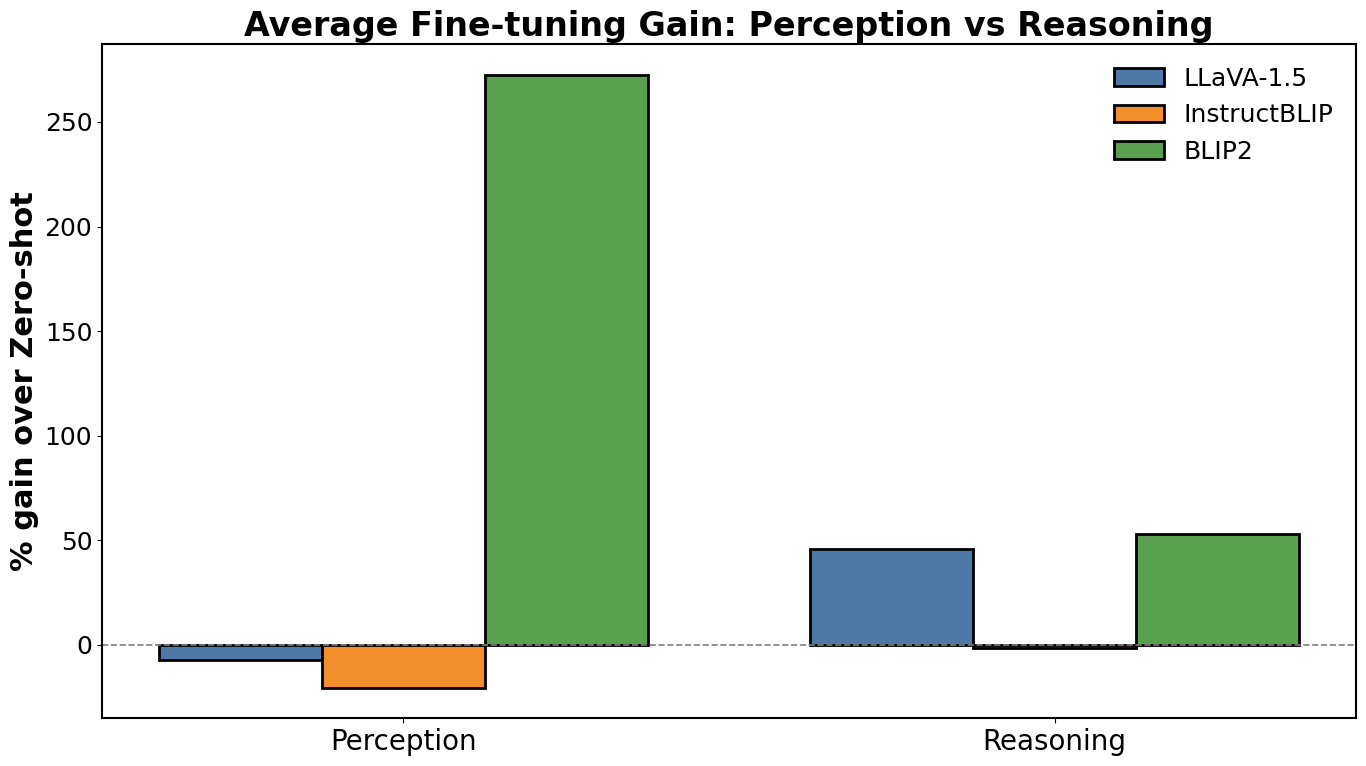

In [34]:
import pandas as pd

# Load CSV
df = pd.read_csv("stats.csv")

mae_metrics = ["Prop_Scalar_MAE", "Obj_Count_MAE"]
f1_metrics = [c for c in df.columns if c not in ["Model", "Setup"] + mae_metrics]

# Compute percent change
records = []
for model in df["Model"].unique():
    zs = df[(df["Model"] == model) & (df["Setup"].str.contains("Zero-shot"))].iloc[0]
    ft = df[(df["Model"] == model) & (~df["Setup"].str.contains("Zero-shot"))].iloc[0]

    changes = {}
    for m in mae_metrics:
        changes[m] = (zs[m] - ft[m]) / zs[m] * 100  # lower is better
    for m in f1_metrics:
        changes[m] = (ft[m] - zs[m]) / zs[m] * 100  # higher is better

    records.append({"Model": model, **changes})

pct_df = pd.DataFrame(records).set_index("Model").round(1)

metric_cols = [c for c in pct_df.columns]      # all 14 %-change columns
long_rows = []
for model in pct_df.index:                     # LLaVA / InstructBLIP / BLIP2
    for metric in metric_cols:
        long_rows.append([model, metric, pct_df.loc[model, metric]])

long_df = pd.DataFrame(long_rows,
                       columns=["Model", "Metric", "Gain_%"])

# Optional: nicer x-labels
metric_map = {
    "Prop_Binary_F1": "PropBin",
    "Prop_Scalar_MAE": "PropMAE",
    "Depth_Cat_F1": "DepthCat",
    "Depth_ClosestObj_F1": "DepthClose",
    "Depth_Binary_F1": "DepthBin",
    "Layout_Binary_F1": "LayBin",
    "Layout_TopEntity_F1": "LayTop",
    "Obj_Count_MAE": "ObjMAE",
    "Obj_Presence_F1": "ObjPres",
    "Obj_Coocc_F1": "ObjCoOcc",
    "Reason_Negation_F1": "Neg",
    "Reason_Counterf_F1": "Ctrf",
    "Reason_Multihop_F1": "Multi",
}
long_df["MetricLbl"] = long_df["Metric"].map(metric_map)
# === 3. Build Perception-vs-Reasoning averages =========================
perception_metrics = [
    "Prop_Binary_F1", "Prop_Scalar_MAE",
    "Depth_Cat_F1", "Depth_ClosestObj_F1", "Depth_Binary_F1",
    "Layout_Binary_F1", "Layout_TopEntity_F1",
    "Obj_Count_MAE", "Obj_Presence_F1", "Obj_Coocc_F1"
]
reasoning_metrics = ["Reason_Negation_F1", "Reason_Counterf_F1", "Reason_Multihop_F1"]

avg_rows = []
for model, row in pct_df.iterrows():
    perc_avg = row[perception_metrics].mean()
    reas_avg = row[reasoning_metrics].mean()
    avg_rows.append([model, "Perception", perc_avg])
    avg_rows.append([model, "Reasoning", reas_avg])

avg_df = pd.DataFrame(avg_rows, columns=["Model", "Group", "Gain_%"])

# === 4. Plot two groups (Perception vs Reasoning) ======================
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(14, 8))

cmap = {"LLaVA-1.5": "#4E79A7", "InstructBLIP": "#F28E2B", "BLIP2": "#59A14F"}
bar_w    = 0.25
x        = np.arange(2)  # 0 for Perception, 1 for Reasoning
groups   = ["Perception", "Reasoning"]

for i, model in enumerate(avg_df["Model"].unique()):
    sub = avg_df[avg_df["Model"] == model]
    ax.bar(
        x + i*bar_w,
        sub["Gain_%"].values,
        width=bar_w,
        color=cmap[model],
        edgecolor="black",
        linewidth=2,
        label=model
    )

# === axis / aesthetics =================================================
ax.set_xticks(x + bar_w)
ax.set_xticklabels(groups, fontsize=20)
ax.set_ylabel("% gain over Zero-shot", fontsize=22, weight='bold')
ax.set_title("Average Fine-tuning Gain: Perception vs Reasoning", fontsize=24, weight='bold')

ax.axhline(0, color='gray', linestyle='--', linewidth=1.2)
#ax.grid(axis='y', linestyle='--', alpha=0.6)

ax.legend(fontsize=18, frameon=False)

for spine in ax.spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()


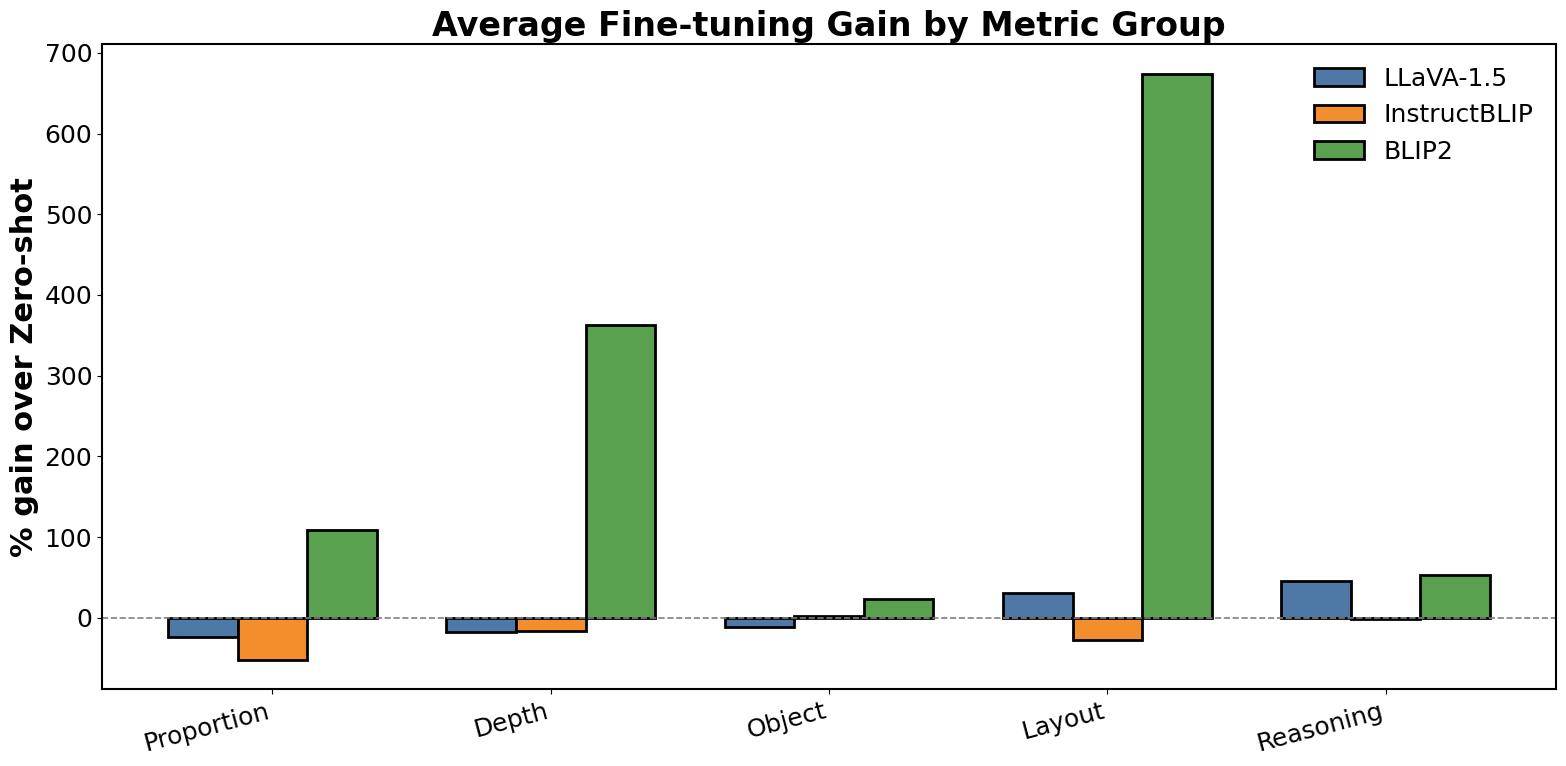

In [35]:
import pandas as pd

# Load CSV
df = pd.read_csv("stats.csv")

mae_metrics = ["Prop_Scalar_MAE", "Obj_Count_MAE"]
f1_metrics = [c for c in df.columns if c not in ["Model", "Setup"] + mae_metrics]

# Compute percent change
records = []
for model in df["Model"].unique():
    zs = df[(df["Model"] == model) & (df["Setup"].str.contains("Zero-shot"))].iloc[0]
    ft = df[(df["Model"] == model) & (~df["Setup"].str.contains("Zero-shot"))].iloc[0]

    changes = {}
    for m in mae_metrics:
        changes[m] = (zs[m] - ft[m]) / zs[m] * 100  # lower is better
    for m in f1_metrics:
        changes[m] = (ft[m] - zs[m]) / zs[m] * 100  # higher is better

    records.append({"Model": model, **changes})

pct_df = pd.DataFrame(records).set_index("Model").round(1)

metric_cols = [c for c in pct_df.columns]      # all 14 %-change columns
long_rows = []
for model in pct_df.index:                     # LLaVA / InstructBLIP / BLIP2
    for metric in metric_cols:
        long_rows.append([model, metric, pct_df.loc[model, metric]])

long_df = pd.DataFrame(long_rows,
                       columns=["Model", "Metric", "Gain_%"])

# Optional: nicer x-labels
metric_map = {
    "Prop_Binary_F1": "PropBin",
    "Prop_Scalar_MAE": "PropMAE",
    "Depth_Cat_F1": "DepthCat",
    "Depth_ClosestObj_F1": "DepthClose",
    "Depth_Binary_F1": "DepthBin",
    "Layout_Binary_F1": "LayBin",
    "Layout_TopEntity_F1": "LayTop",
    "Obj_Count_MAE": "ObjMAE",
    "Obj_Presence_F1": "ObjPres",
    "Obj_Coocc_F1": "ObjCoOcc",
    "Reason_Negation_F1": "Neg",
    "Reason_Counterf_F1": "Ctrf",
    "Reason_Multihop_F1": "Multi",
}
long_df["MetricLbl"] = long_df["Metric"].map(metric_map)
# === 3. Aggregate into five custom groups ==============================
group_defs = {
    "Proportion": ["Prop_Binary_F1", "Prop_Scalar_MAE"],
    "Depth":      ["Depth_Cat_F1", "Depth_ClosestObj_F1", "Depth_Binary_F1"],
    "Object":     ["Obj_Count_MAE", "Obj_Presence_F1", "Obj_Coocc_F1"],
    "Layout":     ["Layout_Binary_F1", "Layout_TopEntity_F1"],
    "Reasoning":  ["Reason_Negation_F1", "Reason_Counterf_F1", "Reason_Multihop_F1"],
}

group_rows = []
for model, row in pct_df.iterrows():
    for g, cols in group_defs.items():
        group_rows.append([model, g, round(row[cols].mean(), 1)])

group_df = pd.DataFrame(group_rows, columns=["Model", "Group", "Gain_%"])

# === 4. Plot (five groups × three models) ==============================
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(16, 8))

colors = {"LLaVA-1.5": "#4E79A7",
          "InstructBLIP": "#F28E2B",
          "BLIP2": "#59A14F"}

bar_w = 0.25
x     = np.arange(len(group_defs))  # 0..4

for i, model in enumerate(group_df["Model"].unique()):
    sub = group_df[group_df["Model"] == model]
    ax.bar(
        x + i*bar_w,
        sub["Gain_%"].values,
        width=bar_w,
        color=colors[model],
        edgecolor="black",
        linewidth=2,
        label=model
    )

# axis / aesthetics
ax.set_xticks(x + bar_w)
ax.set_xticklabels(group_defs.keys(), rotation=15, ha='right')
ax.set_ylabel("% gain over Zero-shot", fontsize=22, weight='bold')
ax.set_title("Average Fine-tuning Gain by Metric Group", fontsize=24, weight='bold')

ax.axhline(0, color='gray', linestyle='--', linewidth=1.2)
#ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend(fontsize=18, frameon=False)

# thicker plot frame
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()


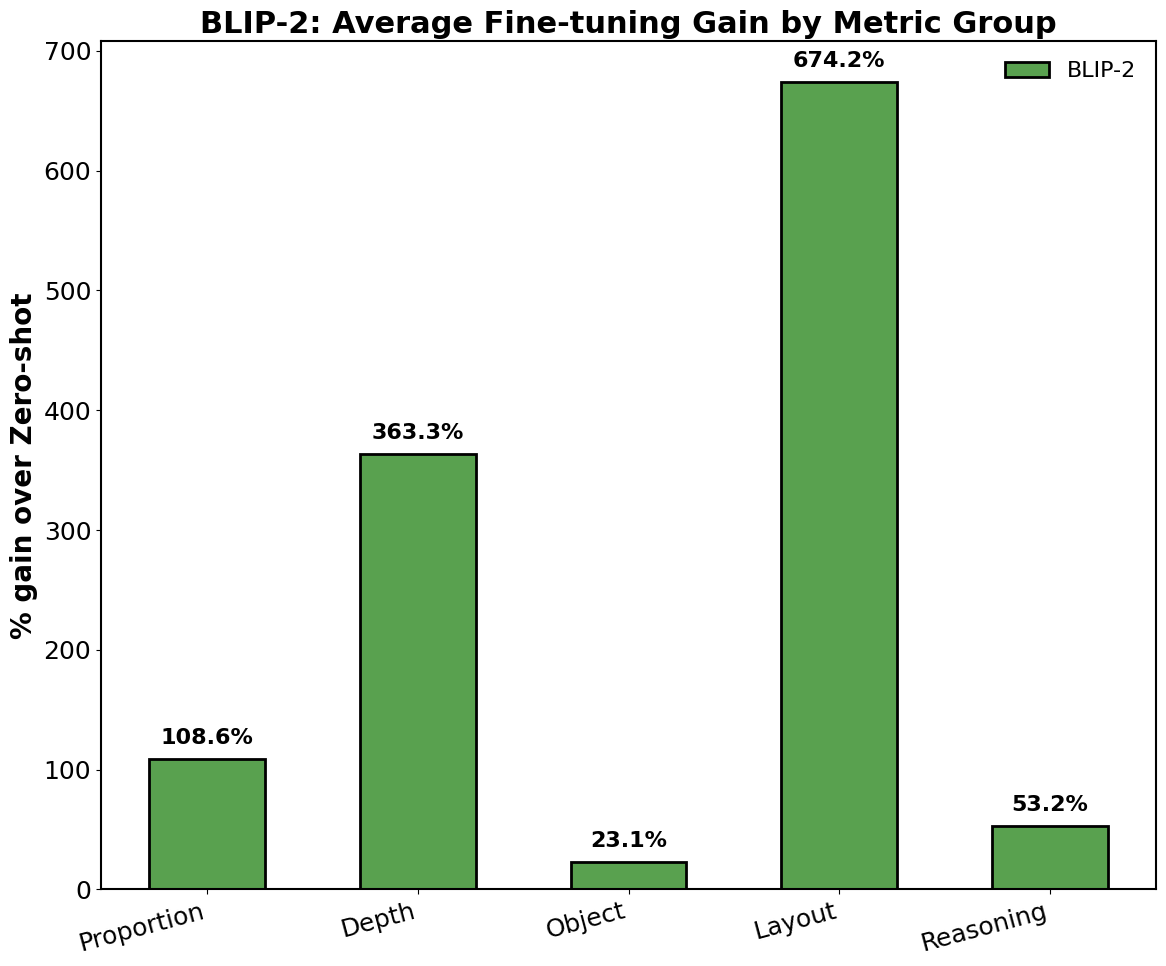

In [ ]:
# -----------------------------  plot_blip2_groups_annotated.py  -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------- #
# 1.  Load CSV                                                        #
# ------------------------------------------------------------------- #
df = pd.read_csv("stats.csv")

mae_metrics = ["Prop_Scalar_MAE", "Obj_Count_MAE"]
f1_metrics  = [c for c in df.columns if c not in ["Model", "Setup"] + mae_metrics]

# ------------------------------------------------------------------- #
# 2.  Compute percent change (FT vs Zero-shot) for each metric        #
# ------------------------------------------------------------------- #
records = []
for model in df["Model"].unique():
    zs = df[(df["Model"] == model) & (df["Setup"].str.contains("Zero-shot"))].iloc[0]
    ft = df[(df["Model"] == model) & (~df["Setup"].str.contains("Zero-shot"))].iloc[0]

    change = {}
    for m in mae_metrics:          # lower MAE → improvement
        change[m] = (zs[m] - ft[m]) / zs[m] * 100
    for m in f1_metrics:           # higher F1 → improvement
        change[m] = (ft[m] - zs[m]) / zs[m] * 100

    records.append({"Model": model, **change})

pct_df = pd.DataFrame(records).set_index("Model").round(1)

# ------------------------------------------------------------------- #
# 3.  Aggregate BLIP-2 gains into five metric groups                  #
# ------------------------------------------------------------------- #
group_defs = {
    "Proportion": ["Prop_Binary_F1", "Prop_Scalar_MAE"],
    "Depth":      ["Depth_Cat_F1", "Depth_ClosestObj_F1", "Depth_Binary_F1"],
    "Object":     ["Obj_Count_MAE", "Obj_Presence_F1", "Obj_Coocc_F1"],
    "Layout":     ["Layout_Binary_F1", "Layout_TopEntity_F1"],
    "Reasoning":  ["Reason_Negation_F1", "Reason_Counterf_F1", "Reason_Multihop_F1"],
}

blip2_row = pct_df.loc["BLIP2"]
group_vals = [round(blip2_row[cols].mean(), 1) for cols in group_defs.values()]

# ------------------------------------------------------------------- #
# 4.  Plot: BLIP-2 only                                               #
# ------------------------------------------------------------------- #
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(12, 10))

x_pos  = np.arange(len(group_defs))        # 0..4
bar_w  = 0.55
color  = "#59A14F"                         # green for BLIP-2

bars = ax.bar(
    x_pos,
    group_vals,
    width=bar_w,
    color=color,
    edgecolor="black",
    linewidth=2,
    label="BLIP-2"
)

# Annotate each bar with its % gain
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f'{height:.1f}%',                       # e.g. "5.2%"
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 8),                          # 8 pts above the bar
        textcoords="offset points",
        ha='center',
        va='bottom',
        fontsize=16,
        fontweight='bold'
    )

# Axis labels and aesthetics
ax.set_xticks(x_pos)
ax.set_xticklabels(group_defs.keys(), rotation=15, ha='right')
ax.set_ylabel("% gain over Zero-shot", fontsize=20, weight='bold')
ax.set_title("BLIP-2: Average Fine-tuning Gain by Metric Group", fontsize=22, weight='bold')

ax.axhline(0, color='gray', linestyle='--', linewidth=1.2)
ax.legend(fontsize=16, frameon=False)

for spine in ax.spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()
# ------------------------------------------------------------------- #


10/13

matplotlib: 3.9.4
Saved: /home/user/JR/research/notebook/iccv_poster_charts/perceptual_tasks_grouped.svg
Saved: /home/user/JR/research/notebook/iccv_poster_charts/perceptual_tasks_grouped.png


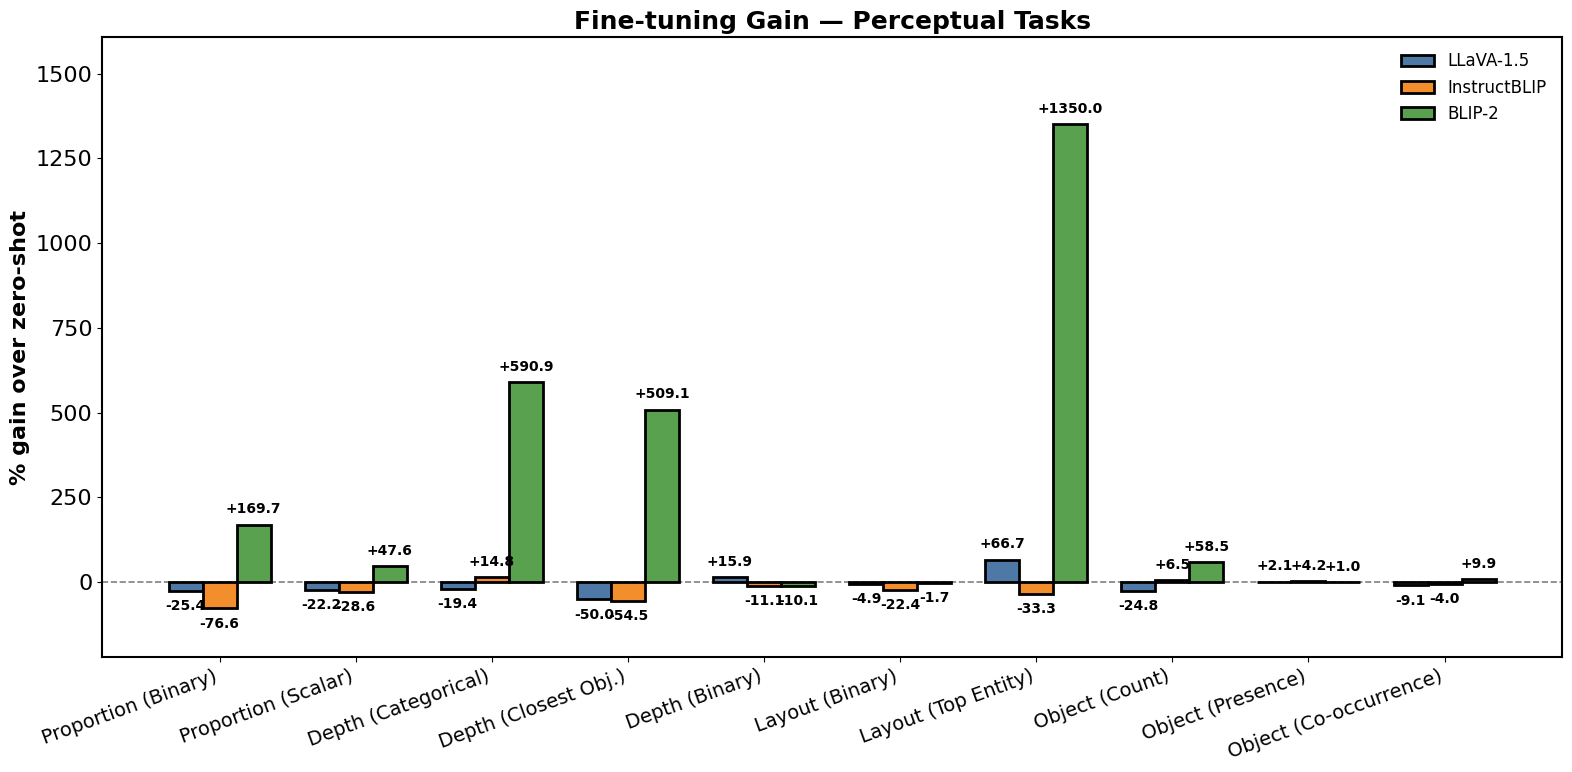

Saved: /home/user/JR/research/notebook/iccv_poster_charts/compositional_tasks_grouped.svg
Saved: /home/user/JR/research/notebook/iccv_poster_charts/compositional_tasks_grouped.png


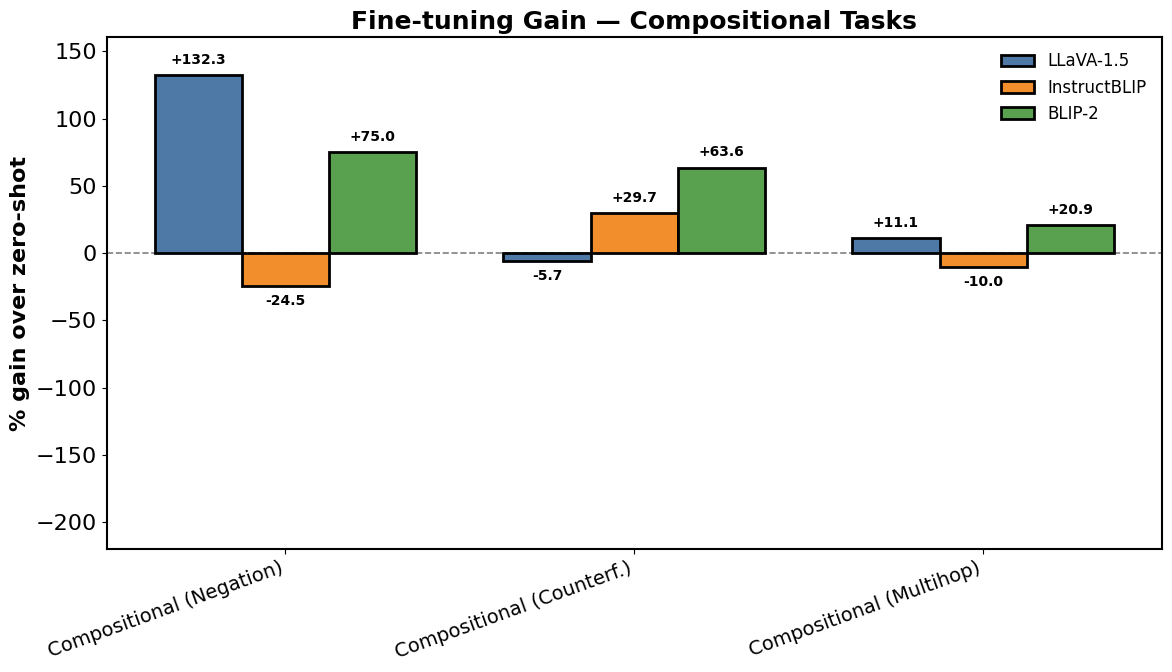

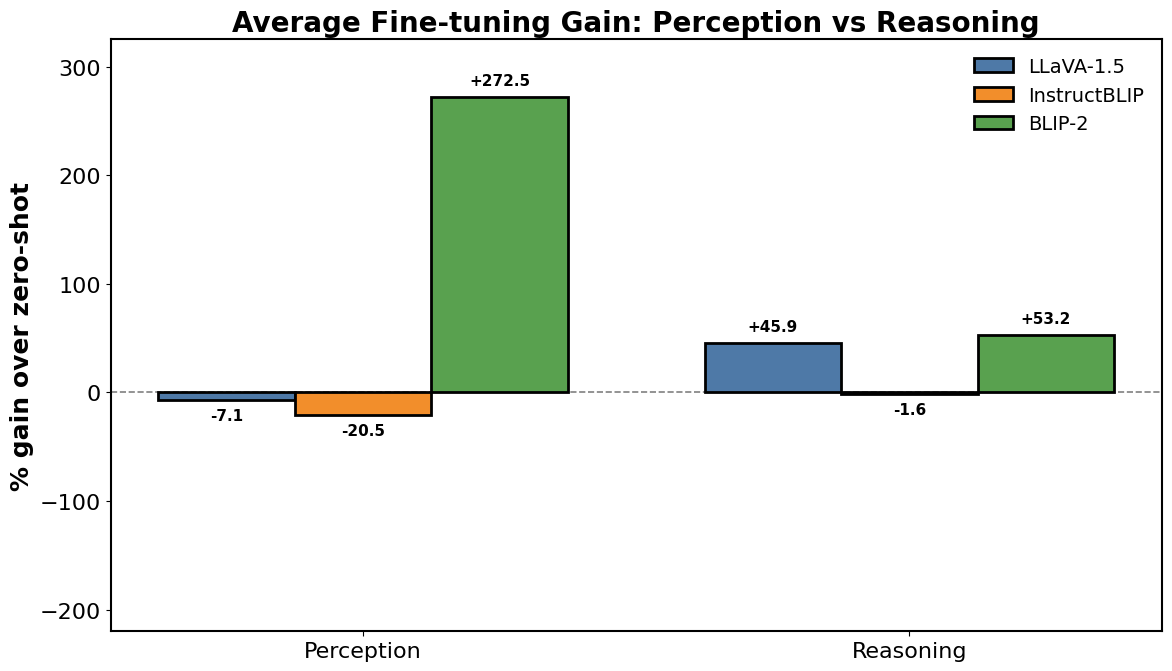

Saved: /home/user/JR/research/notebook/iccv_poster_charts/avg_perception_vs_reasoning.svg
Saved: /home/user/JR/research/notebook/iccv_poster_charts/avg_perception_vs_reasoning.png

✅ All SVG and PNG charts saved in: /home/user/JR/research/notebook/iccv_poster_charts


In [ ]:
# --- ICCV poster charts (Jupyter-ready, SVG + PNG output, fixed labels) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib

print("matplotlib:", matplotlib.__version__)  # needs >= 3.4 for bar_label

# --- Output directory ---
outdir = Path.cwd() / "iccv_poster_charts"
outdir.mkdir(parents=True, exist_ok=True)

# --- Data (percent change vs zero-shot; your revised numbers) ---
data = {
    "Model": ["LLaVA-1.5", "InstructBLIP", "BLIP-2"],
    "Proportion (Binary)":   [-25.4, -76.6, 169.7],
    "Proportion (Scalar)":   [-22.2, -28.6,  47.6],
    "Depth (Categorical)":   [-19.4,  14.8, 590.9],
    "Depth (Closest Obj.)":  [-50.0, -54.5, 509.1],
    "Depth (Binary)":        [ 15.9, -11.1, -10.1],
    "Layout (Binary)":       [ -4.9, -22.4,  -1.7],
    "Layout (Top Entity)":   [ 66.7, -33.3, 1350.0],
    "Object (Count)":        [-24.8,   6.5,  58.5],
    "Object (Presence)":     [  2.1,   4.2,   1.0],
    "Object (Co-occurrence)":[ -9.1,  -4.0,   9.9],
    "Compositional (Negation)":[132.3, -24.5,  75.0],
    "Compositional (Counterf.)":[ -5.7, 29.7,  63.6],
    "Compositional (Multihop)":[ 11.1, -10.0,  20.9],
}
pct_df = pd.DataFrame(data).set_index("Model")

# --- Metric groups ---
perceptual_cols = [
    "Proportion (Binary)", "Proportion (Scalar)",
    "Depth (Categorical)", "Depth (Closest Obj.)", "Depth (Binary)",
    "Layout (Binary)", "Layout (Top Entity)",
    "Object (Count)", "Object (Presence)", "Object (Co-occurrence)"
]
compositional_cols = [
    "Compositional (Negation)", "Compositional (Counterf.)", "Compositional (Multihop)"
]

# --- Colors (reference palette) ---
cmap = {"LLaVA-1.5": "#4E79A7", "InstructBLIP": "#F28E2B", "BLIP-2": "#59A14F"}
plt.rcParams.update({"font.size": 16})

def _set_headroom(ax, values, top_extra=0.18, bottom_extra=0.10, ymin_fixed=-200):
    """Add vertical breathing room so labels at bar edges don't clip."""
    vals = np.asarray(values).ravel()
    ymin = min(0.0, float(vals.min()))
    ymax = max(0.0, float(vals.max()))
    span = (ymax - ymin) if ymax != ymin else 1.0

    # ✅ ymin을 최소 -50으로 고정
    ymin = min(ymin, ymin_fixed)

    ax.set_ylim(ymin - bottom_extra*abs(ymin), ymax + top_extra*span)


def plot_grouped_metrics(df, metrics, title, outfile_stem=None, figsize=(14, 8)):
    """Grouped bars with edge labels (+ for positive), SVG + PNG export."""
    x = np.arange(len(metrics))
    w = 0.25
    models = list(df.index)

    fig, ax = plt.subplots(figsize=figsize)
    containers = []
    for i, model in enumerate(models):
        vals = df.loc[model, metrics].values
        cont = ax.bar(
            x + i*w, vals, width=w, label=model,
            color=cmap[model], edgecolor="black", linewidth=2, zorder=3
        )
        containers.append(cont)

    # Labels at bar tips with + sign
    for cont in containers:
        vals = [r.get_height() for r in cont]
        labels = [f"+{v:.1f}" if v > 0 else f"{v:.1f}" for v in vals]
        ax.bar_label(
            cont, labels=labels, label_type="edge", padding=6,
            fontsize=10, fontweight="bold", clip_on=False, zorder=4
        )

    # Headroom
    _set_headroom(ax, df[metrics].to_numpy())

    # Aesthetics
    ax.set_xticks(x + w)
    ax.set_xticklabels(metrics, rotation=20, ha="right", fontsize=14)
    ax.set_ylabel("% gain over zero-shot", fontsize=16, weight="bold")
    ax.set_title(title, fontsize=18, weight="bold")
    ax.axhline(0, color="gray", linestyle="--", linewidth=1.2, zorder=2)
    ax.legend(fontsize=12, frameon=False)
    for sp in ax.spines.values():
        sp.set_linewidth(1.5)

    plt.tight_layout()
    if outfile_stem:
        svg_path = Path(outfile_stem).with_suffix(".svg")
        png_path = Path(outfile_stem).with_suffix(".png")
        fig.savefig(svg_path, bbox_inches="tight")
        fig.savefig(png_path, bbox_inches="tight", dpi=300)
        print(f"Saved: {svg_path}\nSaved: {png_path}")
    plt.show()

# --- Plot 1: Perceptual tasks ---
plot_grouped_metrics(
    pct_df, perceptual_cols,
    "Fine-tuning Gain — Perceptual Tasks",
    outfile_stem=outdir / "perceptual_tasks_grouped",
    figsize=(16, 8)
)

# --- Plot 2: Compositional tasks ---
plot_grouped_metrics(
    pct_df, compositional_cols,
    "Fine-tuning Gain — Compositional Tasks",
    outfile_stem=outdir / "compositional_tasks_grouped",
    figsize=(12, 7)
)

# --- Averages: Perception vs Reasoning ---
avg_rows = []
for model, row in pct_df.iterrows():
    perc_avg = row[perceptual_cols].mean()
    reas_avg = row[compositional_cols].mean()
    avg_rows.append([model, "Perception", perc_avg])
    avg_rows.append([model, "Reasoning",  reas_avg])

avg_df = pd.DataFrame(avg_rows, columns=["Model", "Group", "Gain_%"])
avg_pivot = avg_df.pivot(index="Model", columns="Group", values="Gain_%").loc[pct_df.index]

fig, ax = plt.subplots(figsize=(12, 7))
x = np.arange(2)
w = 0.25
groups = ["Perception", "Reasoning"]
containers = []
for i, model in enumerate(avg_pivot.index):
    cont = ax.bar(
        x + i*w, avg_pivot.loc[model, groups].values,
        width=w, color=cmap[model], edgecolor="black", linewidth=2, zorder=3, label=model
    )
    containers.append(cont)

for cont in containers:
    vals = [r.get_height() for r in cont]
    labels = [f"+{v:.1f}" if v > 0 else f"{v:.1f}" for v in vals]
    ax.bar_label(cont, labels=labels, label_type="edge", padding=6,
                 fontsize=11, fontweight="bold", clip_on=False, zorder=4)

# Headroom for averages
_set_headroom(ax, avg_pivot[groups].to_numpy())

ax.set_xticks(x + w)
ax.set_xticklabels(groups, fontsize=16)
ax.set_ylabel("% gain over zero-shot", fontsize=18, weight="bold")
ax.set_title("Average Fine-tuning Gain: Perception vs Reasoning", fontsize=20, weight="bold")
ax.axhline(0, color="gray", linestyle="--", linewidth=1.2, zorder=2)
ax.legend(fontsize=14, frameon=False)
for sp in ax.spines.values():
    sp.set_linewidth(1.5)

plt.tight_layout()
avg_out_svg = outdir / "avg_perception_vs_reasoning.svg"
avg_out_png = outdir / "avg_perception_vs_reasoning.png"
fig.savefig(avg_out_svg, bbox_inches="tight")
fig.savefig(avg_out_png, bbox_inches="tight", dpi=300)
plt.show()

print("Saved:", avg_out_svg)
print("Saved:", avg_out_png)
print("\nAll SVG and PNG charts saved in:", outdir.resolve())
